In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
combined = pd.read_csv("../data/skillshare_2022_starts_views_combined.csv", index_col=0)
combined.head()

,user_uid,create_time,success,is_cancelled,payment_provider_cat_codes,payment_ux_cat_codes,trial_length_offer_cat_codes,sub_utm_channel_cat_codes,sub_utm_source_cat_codes,day-1,...,day-22,day-23,day-24,day-25,day-26,day-27,day-28,day-29,day-30,day-31
0,23692129,2022-01-01 00:00:02,0,True,2,2,0,10,30,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23674285,2022-01-01 00:00:27,0,False,-1,-1,0,2,116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16119588,2022-01-01 00:01:19,1,False,1,5,0,10,30,347.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23693101,2022-01-01 00:01:42,0,False,2,2,0,16,55,1211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23692349,2022-01-01 00:02:04,1,False,2,2,0,16,55,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
combined.create_time = pd.to_datetime(combined.create_time)
combined.create_time

0        2022-01-01 00:00:02
1        2022-01-01 00:00:27
2        2022-01-01 00:01:19
3        2022-01-01 00:01:42
4        2022-01-01 00:02:04
                 ...        
475443   2022-05-31 23:56:47
475444   2022-05-31 23:56:53
475445   2022-05-31 23:57:46
475446   2022-05-31 23:58:00
475447   2022-05-31 23:59:21
Name: create_time, Length: 475448, dtype: datetime64[ns]

In [4]:
# Rolling average of churn rate
rolling = combined[["create_time", "success"]]\
    .set_index("create_time")\
    .rolling('5d')

create_time_viz = rolling\
    .mean()\
    .resample('1d')\
    .mean()

std = rolling\
    .std(ddof=0)\
    .resample('1d')\
    .mean()

create_time_viz = pd.DataFrame(create_time_viz)
create_time_viz = create_time_viz.rename(columns={"success":"mean_churn"})
create_time_viz["churn_std"] = std

create_time_viz

,mean_churn,churn_std
create_time,,
2022-01-01,0.281821,0.448866
2022-01-02,0.269102,0.443488
2022-01-03,0.262782,0.440137
2022-01-04,0.264940,0.441299
2022-01-05,0.262391,0.439927
...,...,...
2022-05-27,0.131695,0.337838
2022-05-28,0.100310,0.300229
2022-05-29,0.087170,0.282069


In [5]:
# Groupby day and count all creations (VOLUME)
create_time_viz["volume"] = combined\
        .groupby([pd.Grouper(key="create_time", freq="1d")])["user_uid"]\
        .count()

create_time_viz["vol_ma"] = create_time_viz.volume\
    .rolling(5)\
    .mean()

create_time_viz["vol_std"] = create_time_viz.volume\
    .rolling(5)\
    .std(ddof=0)

create_time_viz

,mean_churn,churn_std,volume,vol_ma,vol_std
create_time,,,,,
2022-01-01,0.281821,0.448866,2889,NaN,NaN
2022-01-02,0.269102,0.443488,3650,NaN,NaN
2022-01-03,0.262782,0.440137,4022,NaN,NaN
2022-01-04,0.264940,0.441299,3930,NaN,NaN
2022-01-05,0.262391,0.439927,4093,3716.8,440.418619
...,...,...,...,...,...
2022-05-27,0.131695,0.337838,2430,2703.6,148.895400
2022-05-28,0.100310,0.300229,2479,2624.4,141.811988
2022-05-29,0.087170,0.282069,2907,2654.0,177.717754


In [6]:
# Going to use area encoding for std dev, so create cols corresponding to area

create_time_viz["churn_std_y1"] = create_time_viz.mean_churn - create_time_viz.churn_std
create_time_viz["churn_std_y2"] = create_time_viz.churn_std + create_time_viz.mean_churn

create_time_viz["vol_std_y1"] = create_time_viz.vol_ma - create_time_viz.vol_std
create_time_viz["vol_std_y2"] = create_time_viz.vol_std + create_time_viz.vol_ma

create_time_viz

,mean_churn,churn_std,volume,vol_ma,vol_std,churn_std_y1,churn_std_y2,vol_std_y1,vol_std_y2
create_time,,,,,,,,,
2022-01-01,0.281821,0.448866,2889,NaN,NaN,-0.167044,0.730687,NaN,NaN
2022-01-02,0.269102,0.443488,3650,NaN,NaN,-0.174386,0.712591,NaN,NaN
2022-01-03,0.262782,0.440137,4022,NaN,NaN,-0.177355,0.702919,NaN,NaN
2022-01-04,0.264940,0.441299,3930,NaN,NaN,-0.176359,0.706239,NaN,NaN
2022-01-05,0.262391,0.439927,4093,3716.8,440.418619,-0.177536,0.702318,3276.381381,4157.218619
...,...,...,...,...,...,...,...,...,...
2022-05-27,0.131695,0.337838,2430,2703.6,148.895400,-0.206143,0.469533,2554.704600,2852.495400
2022-05-28,0.100310,0.300229,2479,2624.4,141.811988,-0.199919,0.400539,2482.588012,2766.211988
2022-05-29,0.087170,0.282069,2907,2654.0,177.717754,-0.194899,0.369240,2476.282246,2831.717754


In [7]:
volume_viz = alt.Chart(
    create_time_viz.reset_index())\
    .mark_line(
        color="blue")\
    .encode(
        x=alt.X("create_time", title=None),
        y=alt.Y("vol_ma:Q", title="Sign up count"))

churn_rate_viz = alt.Chart(
    create_time_viz.reset_index())\
    .mark_line(
        color="green")\
    .encode(
        x=alt.X("create_time", title=None),
        y=alt.Y("mean_churn:Q", title="P1 Conversion"))

alt.layer(volume_viz, churn_rate_viz)\
    .resolve_scale(y='independent')\
    .properties(
        title="Total sign ups and percentage churn (2022)",
        width=700,
        height=600)

alt.LayerChart(...)

In [8]:
churn_std_area = alt.Chart(
    create_time_viz.reset_index())\
    .mark_area(
        opacity=0.2,
        color="green")\
    .encode(
        x=alt.X("create_time", title=None),
        y=alt.Y("churn_std_y1:Q", scale=alt.Scale(zero=False)),
        y2="churn_std_y2:Q")

volume_std_area = alt.Chart(
    create_time_viz.reset_index())\
    .mark_area(
        opacity=0.2,
        color="blue")\
    .encode(
        x=alt.X("create_time", title=None),
        y=alt.Y("vol_std_y1:Q", scale=alt.Scale(zero=False)),
        y2="vol_std_y2:Q")

volume_std_area

alt.Chart(...)

In [9]:
vol_w_std_chart = alt.layer(
    volume_viz, 
    volume_std_area
    )\
    .properties(
        width=700,
        height=600)

vol_w_std_chart

alt.LayerChart(...)

In [10]:
churn_w_std_chart = alt.layer(
    churn_rate_viz,
    churn_std_area
    )\
    .properties(
        width=700,
        height=600)

churn_w_std_chart

alt.LayerChart(...)

In [11]:
alt.layer(
    churn_w_std_chart,
    vol_w_std_chart
    )\
    .resolve_scale(y="independent")\
    .properties(
        title="Total sign ups and percentage churn (2022)",
        width=700,
        height=600)

alt.LayerChart(...)

In [12]:
resampled_rates = combined.set_index("create_time")\
    .resample('1d')\
    .mean()['success']

res = seasonal_decompose(x=resampled_rates, model='additive')

Text(0.513, 0.95, 'Percentage Churn')

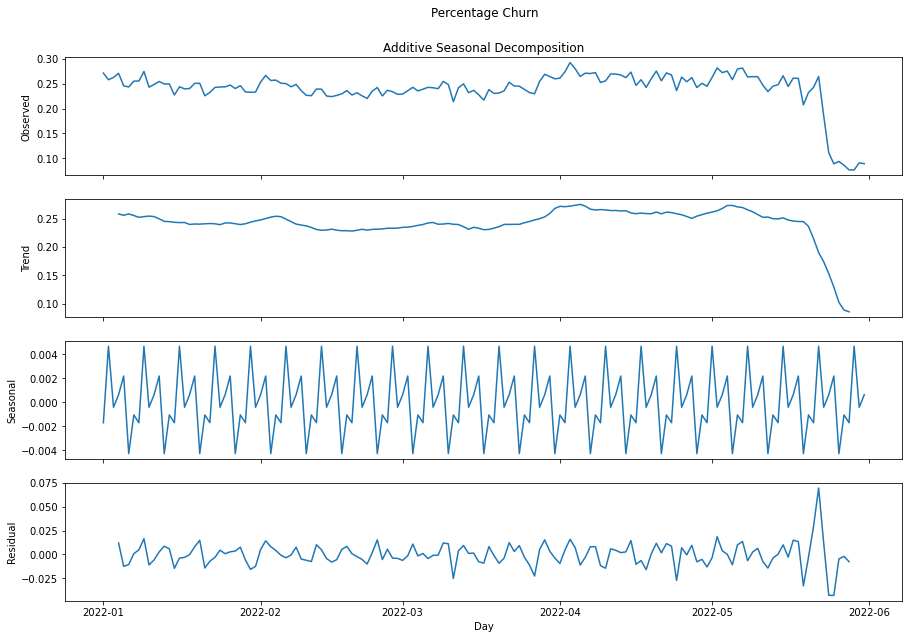

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")
axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")
axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")
axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Day")
fig.suptitle("Percentage Churn", x=0.513, y=0.95)